In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet').drop(columns='date_forecast')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet').drop(columns='date_forecast')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet').drop(columns='date_forecast')

obs_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_A.columns]
est_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_A.columns]
test_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_A.columns]

obs_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_B.columns]
est_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_B.columns]
test_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_B.columns]

obs_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_C.columns]
est_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_C.columns]
test_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_C.columns]

In [3]:
# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

A = A[A['date_forecast'].dt.month.isin([4, 5, 6, 7, 8, 9])]
X_A = A.drop(columns='pv_measurement')
y_A = A['pv_measurement']
unique_days = A['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

B = B[B['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
X_B = B.drop(columns='pv_measurement')
y_B = B['pv_measurement']
unique_days = B['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
X_C = C.drop(columns='pv_measurement')
y_C = C['pv_measurement']
unique_days = C['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
X_train_A = X_train_A.drop(columns='date_forecast')
X_train_B = X_train_B.drop(columns='date_forecast')
X_train_C = X_train_C.drop(columns='date_forecast')
X_val_A = X_val_A.drop(columns='date_forecast')
X_val_B = X_val_B.drop(columns='date_forecast')
X_val_C = X_val_C.drop(columns='date_forecast')
X_A = X_A.drop(columns='date_forecast')
X_B = X_B.drop(columns='date_forecast')
X_C = X_C.drop(columns='date_forecast')

In [4]:
# Inspect data
print(X_A.shape)
print(X_B.shape)
print(X_C.shape)
print(y_A.shape)
print(y_B.shape)
print(y_C.shape)

(16778, 21)
(10331, 21)
(8662, 21)
(16778,)
(10331,)
(8662,)


In [5]:
# XGBoost parameters
xgb_parameters          = {
                            'colsample_bytree': 0.8, 
                            'gamma': 0.8, 
                            'learning_rate': 0.008, 
                            'max_depth': 15, 
                            'min_child_weight': 10, 
                            'n_estimators': 800, 
                            'reg_alpha': 1, 
                            'reg_lambda': 3, 
                            'subsample': 0.912,
                            'random_state': 0, 
                            'booster': 'gbtree'
                        }


catboost_parameters     = { 
                            'subsample': 0.7222222222222222, 
                            'rsm': 0.6111111111111112, 
                            'random_strength': 0.4111111111111111, 
                            'min_data_in_leaf': 19, 
                            'learning_rate': 0.020000000000000004, 
                            'l2_leaf_reg': 1.0, 
                            'iterations': 750, 
                            'grow_policy': 'Depthwise', 
                            'depth': 10, 
                            'border_count': 115, 
                            'bootstrap_type': 'MVS' }

lgbm_parameters         = { 
                            'boosting_type': 'dart',
                            'objective': 'regression',
                            'metric': 'mae',
                            'num_leaves': 100,
                            'learning_rate': 0.05,
                            'verbose': 1,
                            'num_iterations': 300 }
# Define base models
base_models = [
    ('xgb', XGBRegressor(**xgb_parameters, n_jobs=-1)),
    ('lgbm', LGBMRegressor(**lgbm_parameters, n_jobs=-1))
]

# Define meta-model
meta_model = Ridge()

# Define stacking ensemble
stack_A = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, verbose=1)
stack_B = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, verbose=1)
stack_C = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, verbose=1)

In [6]:
# Fit stacking ensemble
stack_A.fit(X_train_A, y_train_A)
pickle.dump(stack_A, open('./stack_models/stack_A.pkl', 'wb'))

stack_B.fit(X_train_B, y_train_B)
pickle.dump(stack_B, open('./stack_models/stack_B.pkl', 'wb'))

stack_C.fit(X_train_C, y_train_C)
pickle.dump(stack_C, open('./stack_models/stack_C.pkl', 'wb'))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3405
[LightGBM] [Info] Number of data points in the train set: 13418, number of used features: 21
[LightGBM] [Info] Start training from score 1052.774650


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3403
[LightGBM] [Info] Number of data points in the train set: 10734, number of used features: 21
[LightGBM] [Info] Start training from score 1078.122830
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 10734, number of used features: 21
[LightGBM] [Info] Start training from score 1012.749647
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.7s finished


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3384
[LightGBM] [Info] Number of data points in the train set: 8271, number of used features: 21
[LightGBM] [Info] Start training from score 234.264650


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3383
[LightGBM] [Info] Number of data points in the train set: 6616, number of used features: 21
[LightGBM] [Info] Start training from score 233.177076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3380
[LightGBM] [Info] Number of data points in the train set: 6617, number of used features: 21
[LightGBM] [Info] Start training from score 236.507372
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.4s finished


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3432
[LightGBM] [Info] Number of data points in the train set: 6934, number of used features: 21
[LightGBM] [Info] Start training from score 182.487194


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 5547, number of used features: 21
[LightGBM] [Info] Start training from score 185.185903
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 5547, number of used features: 21
[LightGBM] [Info] Start training from score 172.377177
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.8s finished


In [7]:
# Evaluate
print('MAE A:', mean_absolute_error(y_val_A, stack_A.predict(X_val_A)))
print('MAE B:', mean_absolute_error(y_val_B, stack_B.predict(X_val_B)))
print('MAE C:', mean_absolute_error(y_val_C, stack_C.predict(X_val_C)))

# Total MAE for all three locations
print('Total MAE:', (mean_absolute_error(y_val_A, stack_A.predict(X_val_A)) + mean_absolute_error(y_val_B, stack_B.predict(X_val_B)) + mean_absolute_error(y_val_C, stack_C.predict(X_val_C)))/3)

MAE A: 308.09198491672885
MAE B: 59.246419608375135
MAE C: 47.41922810807804
Total MAE: 138.25254421106067


In [8]:
# Create submission

output_file = 'stack_submission.csv'

pred_A = stack_A.predict(test_A)
pred_B = stack_B.predict(test_B)
pred_C = stack_C.predict(test_C)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

Submission saved to stack_submission.csv


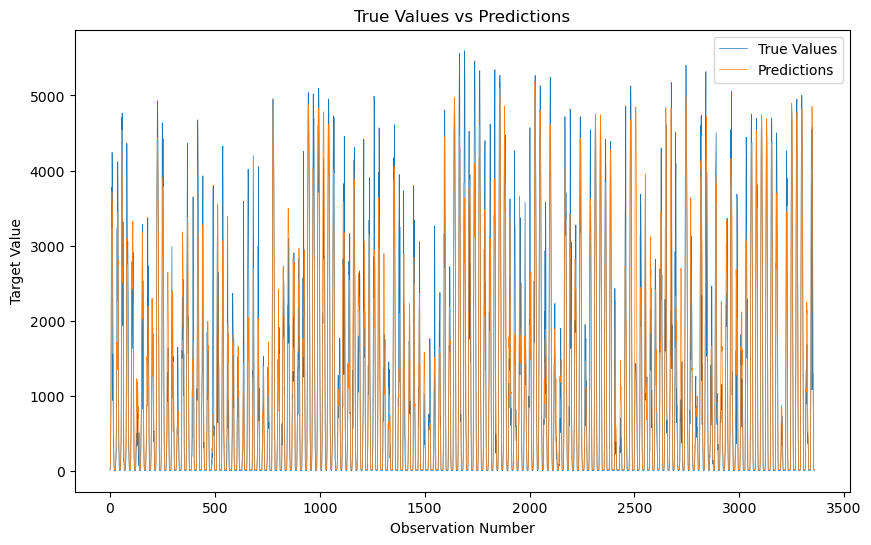

In [9]:
start = 0
stop = 10000

plt.figure(figsize=(10, 6))
plt.plot(y_val_A[start:stop].reset_index(drop=True), label='True Values', linewidth=0.5)
plt.plot(stack_A.predict(X_val_A[start:stop]), label='Predictions', linewidth=0.5)
plt.title('True Values vs Predictions')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.savefig('true_vs_pred.png')
plt.show()